영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

시작하기 전에 우선 주요 라이브러리 버전을 확인해 봅시다.

# Step 1. 데이터 수집하기
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

- [songys/Chabot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)



In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path_chatbotdata = os.getenv("HOME") + "/aiffel/transformer_chatbot/data/ChatbotData .csv"
chatbot_df = pd.read_csv(path_chatbotdata)
chatbot_df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [3]:
# 결측치 확인
print(chatbot_df.isnull().sum())

Q        0
A        0
label    0
dtype: int64


# Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.


In [4]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = chatbot_df.shape[0]
print(MAX_SAMPLES)

11823


In [5]:
# 전처리 함수
def preprocess_sentence(sentence):

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이 student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)      # 여러 공백을 하나의 공백으로

    # (ㄱ~ㅎ, ㅏ-ㅣ, 가~힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅣ가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [6]:
chatbot_df['preprocessed_Q']  = chatbot_df['Q'].map(lambda x : preprocess_sentence(x))
chatbot_df['preprocessed_A']  = chatbot_df['A'].map(lambda x : preprocess_sentence(x))

In [7]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
print('전체 샘플 수 :', len(chatbot_df['preprocessed_Q']))
print('전체 샘플 수 :', len(chatbot_df['preprocessed_A']))
print('전처리 후의 100번째 질문 샘플: {}'.format(chatbot_df['preprocessed_Q'][99]))
print('전처리 후의 100번째 답변 샘플: {}'.format(chatbot_df['preprocessed_A'][99]))

questions = chatbot_df['preprocessed_Q']
answers = chatbot_df['preprocessed_A']

전체 샘플 수 : 11823
전체 샘플 수 : 11823
전처리 후의 100번째 질문 샘플: 거지 같이 일해 놓고 갔어
전처리 후의 100번째 답변 샘플: 일 못하는 사람이 있으면 옆에 있는 사람이 더 힘들죠 .


# Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

1. TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용한다. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩 한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
3. 최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

##  3-1. 단어장(Vocabulary) 만들기

In [8]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [9]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8323]
END_TOKEN의 번호 : [8324]


In [10]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8325


## 3-2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)¶

In [11]:
# 임의의 100번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 100번째 질문 샘플: {}'.format(tokenizer.encode(questions[100])))
print('정수 인코딩 후의 100번째 답변 샘플: {}'.format(tokenizer.encode(answers[100])))

정수 인코딩 후의 100번째 질문 샘플: [1942, 459]
정수 인코딩 후의 100번째 답변 샘플: [500, 7091, 8099, 853, 2454, 44]


In [12]:
# 문장 최대 길이 확인
list_q, list_a = [], []
for i in range(len(questions)):
    line_q = tokenizer.encode(questions[i])
    line_a = tokenizer.encode(answers[i])
    list_q.append(len(line_q))
    list_a.append(len(line_a))
    
print('questions 문장 최대 길이: ', max(list_q))
print('answers 문장 최대 길이: ', max(list_a))

questions 문장 최대 길이:  21
answers 문장 최대 길이:  29


In [13]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20
print(MAX_LENGTH)

20


In [14]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 20 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 20으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [15]:
questions

0                           시 땡 !
1                      지망 학교 떨어졌어
2                     박 일 놀러가고 싶다
3                  박 일 정도 놀러가고 싶다
4                             심하네
                   ...           
11818             훔쳐보는 것도 눈치 보임 .
11819             훔쳐보는 것도 눈치 보임 .
11820                흑기사 해주는 짝남 .
11821    힘든 연애 좋은 연애라는게 무슨 차이일까 ?
11822                  힘들어서 결혼할까봐
Name: preprocessed_Q, Length: 11823, dtype: object

In [16]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8325
필터링 후의 질문 샘플 개수: 11793
필터링 후의 답변 샘플 개수: 11793


## 3-3. 교사 강요(Teacher Forcing) 사용하기

In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


# Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.


In [18]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))  # 나눈 몫이므로 0,0,1,1,2,2,3,3,4,4, ... 
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],          # 행렬을 만들기 위해 axis 추가
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],                  # 행렬을 만들기 위해 axis 추가
            d_model=d_model) 
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, perm=[1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]
#         pos_encoding = tf.concat([sines, cosines], axis=-1)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

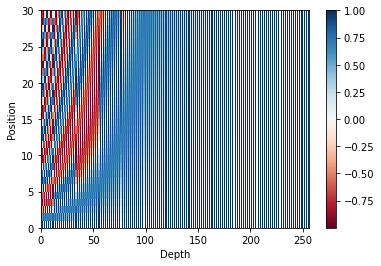

In [19]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [20]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)     # -1 * 10의 9승
                                    # logit 의미를 아래 셀에서 설명
    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    
    return output

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs


In [22]:
# 패딩 마스킹(Padding Masking)
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [23]:
# 확인용
# print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

In [24]:
# 룩 어헤드 마스킹(Look-ahead masking, 단어가리기)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 인코딩


In [25]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [26]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


### 디코딩


In [27]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [28]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


## 모델 정의 및 학습하기

In [29]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


## 하이퍼파라미터 설정 및 손실함수


In [30]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
# VOCAB_SIZE = 8333
NUM_LAYERS = 2    # 인코더와 디코더의 층의 개수
D_MODEL = 256     # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8     # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512       # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1     # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3185408     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [31]:
# 손실함수 
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


In [32]:
# 커스텀된 학습률(learning rate)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

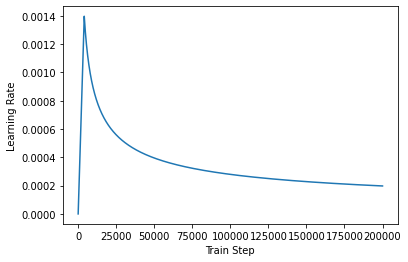

In [33]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델 컴파일

In [34]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


모델 학습

In [35]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 13s 38ms/step - loss: 2.9508 - accuracy: 0.0524
Epoch 2/20
185/185 [==============================] - 7s 37ms/step - loss: 2.3863 - accuracy: 0.1018
Epoch 3/20
185/185 [==============================] - 7s 38ms/step - loss: 2.0449 - accuracy: 0.1041
Epoch 4/20
185/185 [==============================] - 7s 38ms/step - loss: 1.8912 - accuracy: 0.1118
Epoch 5/20
185/185 [==============================] - 7s 38ms/step - loss: 1.7711 - accuracy: 0.1186
Epoch 6/20
185/185 [==============================] - 7s 38ms/step - loss: 1.6465 - accuracy: 0.1275
Epoch 7/20
185/185 [==============================] - 7s 38ms/step - loss: 1.5126 - accuracy: 0.1394
Epoch 8/20
185/185 [==============================] - 7s 38ms/step - loss: 1.3638 - accuracy: 0.1556
Epoch 9/20
185/185 [==============================] - 7s 38ms/step - loss: 1.2050 - accuracy: 0.1732
Epoch 10/20
185/185 [==============================] - 7s 38ms/step - loss: 1.0376 - accur

# Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.




In [36]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [37]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence


In [40]:
sentence_generation('하고싶은거 있니')

입력 : 하고싶은거 있니
출력 : 잘 지내고 있어요 .


'잘 지내고 있어요 .'

In [39]:
sentence_generation("공부할게 너무 많다")

입력 : 공부할게 너무 많다
출력 : 나중에 후회할 거예요 .


'나중에 후회할 거예요 .'

# Step 6. 회고


- RNN을 사용하지 않고 순차적인 정보를 넣기 위해 positional encoding을 사용하였고 작동원리와 코드 구현에 많은 시간을 투자했다
- 어텐션이 무엇인지 알게 되었으며 어텐션을 기점으로 NLP에서 커다란 혁신이 일어났음을 알았다
- 실습에서는 txt파일이라서 전처리할 때 load 함수를 만들어 사용하였으나 이번 프로젝트에서는 csv파일이라서 전처리가 쉬웠다
- 트랜스포머에 대해서 동영상 강의와 핸즈온 책을 찾아보면서 공부했는데 제대로 이해하지 못하였다. 계속해서 자료를 찾아보면서 공부해야겠다
- 이번 노드에서 어려웠던 것은 이론도 어려웠는데 코드 자체를 이해하는게 너무나 힘들었다. 코드 몇 개는 아직도 이해가 되지 않았고 여러 사람과 같이 공부하면서 이해해야 할 것 같다.
- 코드 이해가 되지 않은 부분이 많아서 인터넷에서 자료를 참조한 부분이 있었기 때문에 트랜스포머 관련 코드는 계속 찾아보면서 익혀야겠다